In [46]:
using Wavelets
using PyPlot
using WAV

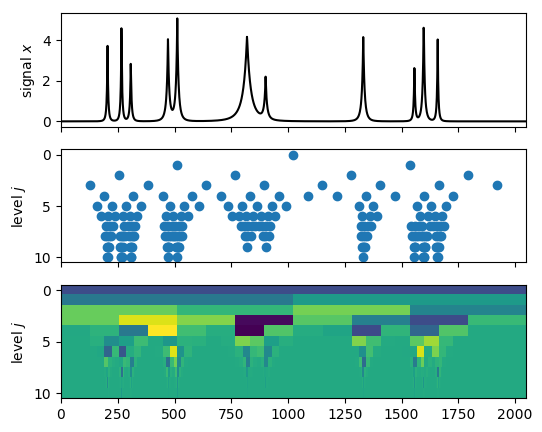

In [47]:
J = 11
n = 2^J
x = testfunction(n,"Bumps")

y = dwt(x, wavelet(WT.db2))
d,l = wplotdots(y, 0.1, n)
A = wplotim(y)

f, ax = plt[:subplots](3, 1, sharex=true)
ax[1][:plot](x, "k")
ax[1][:set_xlim]([0,n])
ax[1][:set_ylabel](L"signal $x$")
ax[2][:scatter](d,l)
ax[2][:margins](0.05)
ax[2][:set_ylim](ax[2][:get_ylim]()[2:-1:1])
ax[2][:set_ylabel](L"level $j$")
ax[3][:imshow](A,aspect="auto",interpolation="none")
ax[3][:set_ylim]([J-0.5,-0.5])
ax[3][:set_ylabel](L"level $j$")

f[:set_size_inches](6,5)

In [48]:
x = [0:7999;]
y = sin.(2 * pi * x / 8000)
wavwrite(y, "example.wav", Fs=8000)
y, fs = wavread("example.wav")
y = cos.(2 * pi * x / 8000)
wavappend(y, "example.wav")
y, fs = wavread("example.wav")
wavplay(y, fs)

In [174]:
# padzero: append zeros to increase length such that its divisible by n
function padzero(f,n)
    padf = zeros(cld(length(f),n)*n,1)
    padf[1:length(f)] = f
    padf
end

# splitblocks: split signal f into blocks of length n
function splitblocks(f, n)
    [f[i:min(i+n-1,length(f))] for i in 1:n:length(f)]
end

# downsample: downsample signal by half
function downsample(f)
    f[1:2:end-1]+f[2:2:end]
end

# minrmse: alpha,beta parameters minimizing collage error
function minrmse(R,D)
    A = zeros(2,2)
    A[1,1] = sum(D.*D)
    A[1,2] = A[2,1] = sum(D)
    A[2,2] = length(D)
    B = zeros(2,1)
    B[1] = sum(R.*D)
    B[2] = sum(R)
    alpha,beta = A\B
end

# rmse: root mean squared error
function rmse(x,y)
    sqrt(sum((x-y).^2)/length(x))
end

# twoscaleencoder: encodes signal f with range blocks sized n, domain blocks sized 2n
function twoscaleencoder(f,n)
    f = padzero(f,2n)
    R = splitblocks(f,n)
    D = map(downsample, splitblocks(f,2n))
    code = []
    errs = zeros(length(R),1)
    println(string("Range blocks: ",length(R)))
    for i = 1:length(R)
        if (i%1000==0) println(i) end
        Ri = R[i]
        besterr = 1
        alpha = 1; beta = 1; bestj = 0
        for j = 1:length(D)
            Dj = D[j]
            a,b = minrmse(Ri,Dj)
            err = rmse(Ri, a*Dj+b)
            if err < besterr
                besterr = err
                alpha = a; beta = b; bestj = j
            end
        end
        push!(code, (i,bestj,alpha,beta))
    end
    code
end

function fractaltransform(f,code,n)
    D = map(downsample, splitblocks(f,2n))
    vcat([alpha*D[j]+beta for (i,j,alpha,beta) in code]...)
end

function twoscaledecoder(code,n)
    f = padzero(zeros(length(code)*n,1),2n)
    tol = 1e-5
    err = 1
    while err > tol
        g = f
        f = fractaltransform(g,code,n)
        err = rmse(f,g)
    end
    f
end


twoscaledecoder (generic function with 1 method)

Range blocks: 3726
1000
2000


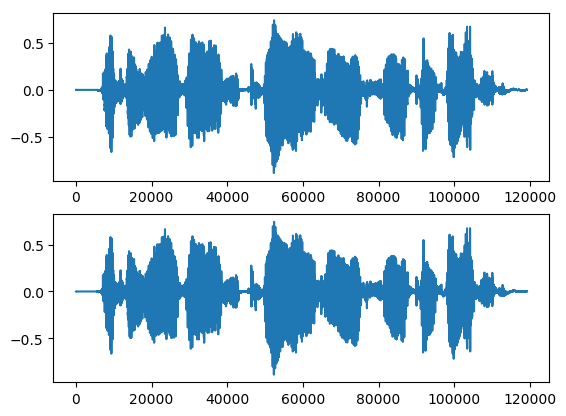

3000


In [195]:
function ifstest()
    y, fs = wavread("voice.wav")
    fig,ax = plt[:subplots](2,1)
    ax[1][:plot](y[:,1])
    ax[2][:plot](y[:,2])

    y = (y[:,1]+y[:,2])*0.5

    n = 32
    y = padzero(y,2n)
    # encode/decode
    code = twoscaleencoder(y,n)
    yapprox = twoscaledecoder(code,n)
    # write audio file
    wavwrite(yapprox, "voice_compress.wav", Fs=fs)
    wavplay(yapprox, fs)    
    
    function writefif(code, n)
        codestring = c -> string(c[2]," ",c[3]," ",c[4],"\n")
        open("./testcode.fif", "w") do fif
            write(fif, string(n,"\n"))
            for i = 1:length(code)
                write(fif, codestring(code[i]))
            end
        end
    end
    writefif(code,n)
end
ifstest()